# Bert Training with Early Stopping

## 0. Setup

### 0.1 Install libraries

In [392]:
! pip install -r requirements.txt

# If you work with GPU-support:
! pip install torch==2.7.1+cu128 -f https://download.pytorch.org/whl/torch/
! pip install torchaudio==2.7.1+cu128 -f https://download.pytorch.org/whl/torchaudio/
! pip install torchvision==0.22.1+cu128 -f https://download.pytorch.org/whl/torchvision/

# If you only work with CPU-support:
# ! pip install torch==2.7.1
# ! pip install torchaudio==2.7.1
# ! pip install torchvision==0.22.1


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torch/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchaudio/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchvision/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 0.2 GPU setup

In [393]:
# Check if CUDA is available and print the current device's name
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 2070 with Max-Q Design


## 1 Configuration

In [399]:
# Data variables
data_path = "../../data/training_data/labeled/labeled_data.xlsx" # path to the Excel file with the labeled data
validation_path = "../../data/validation_data/validation_data.csv" # path to where the validation set should be stored
results_path = "../../data/training_data/labeled/model_performance.csv" # path to where the results should be stored
text_column_name = "expanded" # name of the column containing the text to classify
label_column_name = "label_strict" # name of the column containing the labels (0 = correct or 1 = incorrect)
num_labels = 2 # binary classification (see above)

# Model configuration
model_name = "bert-base-uncased" # standard; I specify other models in the "3. Initialize Models" section of this script
test_size = 0.2 # ratio of the dataset to be used for testing
max_length = 350 # maximum length of the input sequences for BERT
num_epochs = 10 # number of epochs for training
batch_size = 8 # batch size for training and evaluation
learning_rate = 2e-5 # learning rate for the optimizer
weight_decay = 0.01 # weight decay for the optimizer
early_stopping_patience = 2 # number of epochs with no improvement after which training will be stopped

# Seed for reproducibility
import random
import numpy as np
from transformers import set_seed
import os

seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
set_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



## 2 Read and prepare dataset

In [397]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_excel(data_path)

# Remove all columns but 'expanded' and 'label_strict'
df = df.drop(columns=['statement_id', 'section', 'header','div', 'p', 's', 'article_id', 'p_comp', 'p_value', 'context', 'text', 'label_kind', 'label_keywords', 'label_comment'])

# Change column names
df = df.rename(columns={text_column_name: 'text', label_column_name: 'label'})

# Remove rows where 'label' is NA
df = df[df['label'].notna()]

# Put 20 % of the data (with labels 0, 1, or -99) into a validation set
df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=seed
)

# Save validation set as 'validation_data.csv' at 'validation_path'
val_df.to_csv(validation_path, index=False)

# Remove rows where 'label' is -99
df = df[df['label'] != -99]

# Convert label column to int (required for classification)
df['label'] = df['label'].astype(int)

# Balance labels via undersampling (generalized)
label_counts = df['label'].value_counts()  # Get counts of each label
minority_label = label_counts.idxmin() # Get the minority label
majority_label = label_counts.idxmax() # Get the majority label

df_minority = df[df['label'] == minority_label]
df_majority = df[df['label'] == majority_label]

df_majority_downsampled = resample( # Downsample majority label
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=seed
)

df = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=seed).reset_index(drop=True)

# Show head
df.head()

,text,label
0,There were no significant differences between ...,0
1,There was no interaction between age group and...,1
2,Opponent height was subsequently added as a fi...,0
3,"Interestingly, however, participants' explicit...",1
4,When participants made large errors on previou...,1


### 2.1 Create Train/Test set

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
df_train, df_test = train_test_split(df, test_size=test_size, random_state=seed, stratify=df['label'])

# Convert to Huggingface dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

Header of the Training set:

In [355]:
df_train.head()

,text,label
474,Neither the reaction time nor the proportion o...,1
617,"As expected, prior to the intervention (at bas...",1
316,There was no main effect of statistical-learni...,1
13,We found the same pattern for RTs: A 7 (Positi...,0
282,We also confirmed the predicted familiarity-by...,1


In [356]:
# Check label balance in training set
print("Training label distribution:")
print(df_train['label'].value_counts())

Training label distribution:
label
1    213
0    212
Name: count, dtype: int64


Header of the Test set:

In [357]:
df_test.head()

,text,label
59,There was no significant difference between th...,0
375,There was no difference in general inclination...,1
349,"However, an examination of the zero-order asso...",1
590,"Similarly, there was no significant relationsh...",0
515,Neither of the deprived states modulated subje...,1


In [358]:
# Check label balance in test set
print("Test label distribution:")
print(df_test['label'].value_counts())

Test label distribution:
label
0    54
1    53
Name: count, dtype: int64


### 2.2 Tokenize 'text'

In [359]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_for_bert(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=max_length)

tokenized_train = train_dataset.map(tokenize_for_bert, batched=True)

tokenized_test = test_dataset.map(tokenize_for_bert, batched=True)

Map: 100%|██████████| 107/107 [00:00<00:00, 3421.26 examples/s]


## 3 Train BERT

### 3.1 Initializing model

In [360]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2 Training regular BERT

In [ ]:
# Standard Setup for training a model with Huggingface Transformers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import EarlyStoppingCallback
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=learning_rate, # Specify learning rate for BERT
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    logging_strategy="epoch",
    report_to="none",
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    seed=seed
)

# Model specific setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)]  # Stop training if no improvement after 2 epochs
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_3860\1451787568.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [373]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.202800,0.477470,0.887850,0.872727,0.905660,0.888889
2,0.060100,0.512409,0.906542,0.938776,0.867925,0.901961
3,0.040300,0.603119,0.906542,0.938776,0.867925,0.901961


TrainOutput(global_step=162, training_loss=0.10109624744933328, metrics={'train_runtime': 70.1342, 'train_samples_per_second': 60.598, 'train_steps_per_second': 7.7, 'total_flos': 181492669876500.0, 'train_loss': 0.10109624744933328, 'epoch': 3.0})

#### 3.2.1 Save last model

In [378]:
# Save the best model and tokenizer
trainer.save_model("./best_model")
tokenizer.save_pretrained("./best_model")

('./best_model\\tokenizer_config.json',
 './best_model\\special_tokens_map.json',
 './best_model\\vocab.txt',
 './best_model\\added_tokens.json',
 './best_model\\tokenizer.json')

### 3.3 Evaluate model

#### 3.3.1 Predict training data

In [379]:
from sklearn.metrics import classification_report

train_preds = trainer.predict(tokenized_train)
train_preds = np.argmax(train_preds.predictions, axis=1)
GT_train = df_train['label'].tolist()
print("Training Classification Report:")
print(classification_report(GT_train, train_preds))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       212
           1       0.99      0.99      0.99       213

    accuracy                           0.99       425
   macro avg       0.99      0.99      0.99       425
weighted avg       0.99      0.99      0.99       425



#### 3.3.2 Predict test data

In [380]:
test_preds = trainer.predict(tokenized_test)
test_preds = np.argmax(test_preds.predictions, axis=1)
GT_test = df_test['label'].tolist()
print("Test Classification Report:")
print(classification_report(GT_test, test_preds))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        54
           1       0.87      0.91      0.89        53

    accuracy                           0.89       107
   macro avg       0.89      0.89      0.89       107
weighted avg       0.89      0.89      0.89       107



#### 3.3.3 4.3.3 Confusion-Matrix for test data

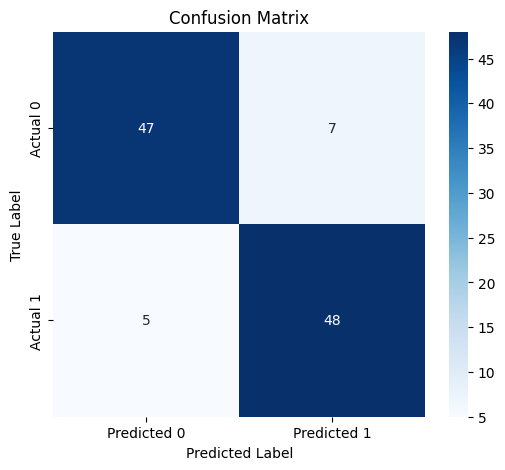

In [381]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT_test, test_preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [367]:
# F1 score printout
from sklearn.metrics import f1_score
print(f"Test F1 score: {f1_score(GT_test, test_preds):.3f}")

Test F1 score: 0.837


#### 3.3.4 List of statements per category (TP, TN, FP, FN)

In [368]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = test_preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [369]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 41)


,text
0,There was no difference in general inclination...
1,"However, an examination of the zero-order asso..."
2,Neither of the deprived states modulated subje...
3,"At pretest, the groups did not differ, F(2, 72..."
4,There was no interaction between stimuli type ...
5,"Although the number of morphs identified as ""d..."
6,Simple-slopes analyses revealed that there was...
7,Lottery choices were not predicted by particip...
8,Post hoc examination (based on standardized ch...
9,As the three conditions were very similar in s...


In [370]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 50)


,text
0,There was no significant difference between th...
1,"Similarly, there was no significant relationsh..."
2,"As in Experiments 1 and 2, participants' accur..."
3,We found no gender differences in task perform...
4,"As in the previous studies, we examined the re..."
5,"However, there was not a significant effect of..."
6,"Contrary to Study 2, results showed no signifi..."
7,There were no significant relationships betwee...
8,Because the three-way interaction was nonsigni...
9,"Crucially, there was no significant interactio..."


In [371]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 4)


,text
0,"For the mid-scale questions, we found no diffe..."
1,The learning bias for the self condition and t...
2,"Again, results indicated that endorsement of d..."
3,"In Experiment 2 (but not Experiment 1), there ..."


In [372]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 12)


,text
0,Our assertion was supported in RTs (classic fa...
1,Logistic barriers did not prove to be a greate...
2,We observed no such increase in the congruent ...
3,Follow-up analyses revealed a significant Trea...
4,"First, using a pilot sample of children who pr..."
5,"However, the absence of a postresponse effect ..."
6,We next focused on report error and found a ma...
7,"As in the previous studies, we found no correl..."
8,"With regard to hit rate, there was no main eff..."
9,The interaction between valence and target was...


## 4 Storing results

### 4.1 Performance over the epochs

In [ ]:
# CODE HERE

### 4.2 Final performance on test set

In [ ]:
# CODE HERE

In [128]:
# The end...